## Netcdf: Select closest points using CKDTree


In this post, we are going to define an algorithm to locate the closest points to a reference point, by using coordinate transformations, k-dimensional trees, and xarray pointwise indexing.


To select closest grid points, we will use here one approach using [cKDTree](http://docs.scipy.org/doc/scipy-0.12.0/reference/generated/scipy.spatial.cKDTree.html) class from scipy.spatial package.


Different method are considered here: 

    - nearest neighbour
    - nearest neighbours, weighting with the inverse of distance squared: 
    
   $T_t = \frac{\sum_{i=1}^{m}T_{s,i}w_i}{\sum_{i=1}^{m}w_i}$, $w_i = 1/d_i^2$).
    
    - query ball point : Find all pairs of points whose distance is at most one distance
    
    
###  Let's import Python librairies   

In [1]:
#for Netcdf manipulation
#import netCDF4
#from netCDF4 import Dataset
import xarray as xr

#for array manipulation
import numpy as np
import pandas as pd

#for plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pylab as plt

#for interpolation
from scipy.spatial import cKDTree

D:\Utilisateurs\guillaume\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
D:\Utilisateurs\guillaume\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


###  Loading Netcdf files   

We are going to use daily ERA5 reanalysis data from April 1st to 31th of october 2018.

In [2]:
unique_dataDIR = 'K:/PROJETS/PROJET_FIRE_INDEX/ERA5_FWI_Netcdf/ERA5_FWI_QC_SNOW_New_2018_from_4_to_8.nc'
TAS = xr.open_dataset(unique_dataDIR)
TAS.lon.shape, TAS.lat.shape,

((121,), (77,))

Regrid 1D latitude and longitude to 2D grid. 

In [3]:
lon2d, lat2d = np.meshgrid(TAS.lon, TAS.lat)
lon2d.shape, lat2d.shape

((77, 121), (77, 121))

Let’s have a quick look at our dataset, we will plot one day in our time range:

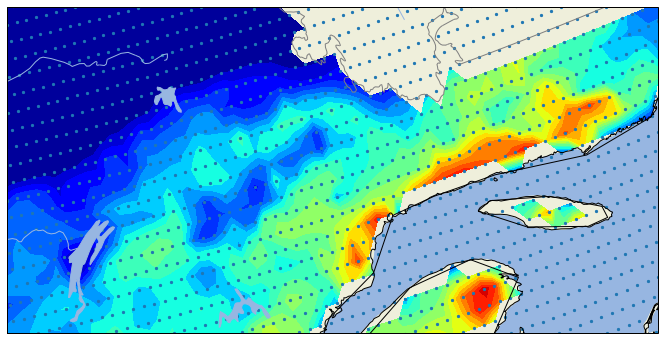

In [4]:
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-75,-60,50,52])
ax.coastlines(resolution='110m');
ax.add_feature(cfeature.OCEAN.with_scale('50m'))      
ax.add_feature(cfeature.LAND.with_scale('50m'))       
ax.add_feature(cfeature.LAKES.with_scale('50m'))     
ax.add_feature(cfeature.BORDERS.with_scale('50m'))    
ax.add_feature(cfeature.RIVERS.with_scale('50m'))    
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',    
                        facecolor='none', name='coastline')
ax.add_feature(coast, edgecolor='black')

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

ax.add_feature(states_provinces, edgecolor='gray')

cmap0=plt.cm.jet
cmap0.set_under('darkblue') 
cmap0.set_over('darkred') 

mm = ax.contourf(TAS.lon,\
                   TAS.lat,\
                   TAS.sel(time='2018-08-01').FWI,\
                   vmin=0,\
                   vmax=20, \
                   transform=ccrs.PlateCarree(),\
                   levels=np.arange(0, 20, 1.0),\
                   cmap=cmap0 )
ax.scatter(lon2d, lat2d, transform=ccrs.PlateCarree(), s=5)

The blue dots in the plot identify the grid points.

What we want to achieve is to come up with a way to compare distances between a reference point (defined by latitude and longitude values), and all grid points, and pick the minimum value. 

But first, we need to measure distances between two points on our planet, given their geodetic (latitude/longitude/altitude) coordinates.

In this post, we are going to use the cartesian or ECEF (“earth-centered, earth-fixed”) geographic coordinate system, which represents positions (in meters) as X, Y, and Z coordinates, approximating the earth surface as an ellipsoid of revolution (close enough for our purposes). 

Once we convert our latitude/longitude coordinates to cartesian coordinates, measuring the distance between two points is as simple as computing the Euclidean distance between them.

The conversion between cartesian and geodetic coordinates latitude, longitude is done according to:

⎡⎣⎢XYZ⎤⎦⎥=⎡⎣⎢rncosϕcosλrncosϕsinλ(1−e2)rnsinϕ⎤⎦⎥


Where rn=a1−e2sin2ϕ√ is the local curvature of the ellipsoid along the first vertical, and where e, the first eccentricity, and a, the semi-major axis, are the parameters defining the ellipsoid. 


Finding the closest

Our problem falls into the class of nearest neighbour searches. A common approach when it comes to finding the nearest neighbour in a number of points with k dimensions is to use a KD-tree, or k-dimensional tree. 
SciPy library provides a very efficient KD-tree implementation . Once we have constructed our tree, all we have to do is to populate it with a (n,m) shaped array of points and then query it the nearest neighbor to a reference point. 

We will have to make use of some NumPy acrobatics to reshape our data structures from a two-dimensional grid to a one-dimensional array, and to convert the returned one-dimensional index to a set of two indices on our original grid.


In [5]:
class KDTreeIndex():    
    """ A KD-tree implementation for fast point lookup on a 2D grid
    
    Keyword arguments: 
    dataset -- a xarray DataArray containing lat/lon coordinates
               (named 'lat' and 'lon' respectively)               
    """    
    def transform_coordinates(self, coords):
        """ Transform coordinates from geodetic to cartesian
        
        Keyword arguments:
        coords - a set of lan/lon coordinates (e.g. a tuple or 
                 an array of tuples)
        """
        # WGS 84 reference coordinate system parameters
        A = 6378.137 # major axis [km]   
        E2 = 6.69437999014e-3 # eccentricity squared    
        
        coords = np.asarray(coords).astype(np.float)
        
        # is coords a tuple? Convert it to an one-element array of tuples
        if coords.ndim == 1:
            coords = np.array([coords])
        
        # convert to radiants
        lat_rad = np.radians(coords[:,0])
        lon_rad = np.radians(coords[:,1]) 
        
        # convert to cartesian coordinates
        r_n = A / (np.sqrt(1 - E2 * (np.sin(lat_rad) ** 2)))
        x = r_n * np.cos(lat_rad) * np.cos(lon_rad)
        y = r_n * np.cos(lat_rad) * np.sin(lon_rad)
        z = r_n * (1 - E2) * np.sin(lat_rad)
        
        return np.column_stack((x, y, z))
    
    def __init__(self, dataset):
        # store original dataset shape
        self.shape = dataset.shape
        lon2d, lat2d = np.meshgrid(dataset.lon, dataset.lat)
        # reshape and stack coordinates
        coords = np.column_stack((lat2d.ravel(),
                                  lon2d.ravel()))
        
        # construct KD-tree
        self.tree = cKDTree(self.transform_coordinates(coords))
        
    def query(self, point, k):
        """ Query the kd-tree for nearest neighbour.
        Keyword arguments:
        point -- a (lat, lon) tuple or array of tuples
        """
        d, inds  = self.tree.query(self.transform_coordinates(point),k=k)
        w = 1.0 / d**2
        # regrid to 2D grid
        indslatlon = np.unravel_index(inds, self.shape)
        return d, inds, w, indslatlon
    
    def query_ball_point(self, point, radius):
        """ Query the kd-tree for all point within distance 
        radius of point(s) x
        
        Keyword arguments:
        point -- a (lat, lon) tuple or array of tuples
        radius -- the search radius (km)
        """
        
        index = self.tree.query_ball_point(self.transform_coordinates(point),
                                           radius)

        # regrid to 2D grid 
        index = np.unravel_index(index[0], self.shape)
        
        # return DataArray indexers
        return xr.DataArray(index[0], dims='lat'), \
               xr.DataArray(index[1], dims='lon')
    

We will construct our cKDTree object using one time step from our xarray. 

In [6]:
latlon_tree = KDTreeIndex(TAS.sel(time='2018-08-01').FWI)

We can now query the tree the nearest grid point to one reference point: 

### Nearest neighbour k=1:

Let's select reference point defined by:
    - latitude = 50 degN
    - longitude = -68.1461 degE 
    
We can now query the tree the nearest point :

In [7]:
site = (50, -68.1461)
d, inds, w, indslatlon = latlon_tree.query(site, k=1)
print(inds)
print(indslatlon)

[5871]
(array([48], dtype=int64), array([63], dtype=int64))


In [8]:
latpt = indslatlon[0][0]
lonpt = indslatlon[1][0]
print(latpt, lonpt)

48 63


The query method actually  returns:
- two array objects a latitude and a longitude indexer
- one 1D indexer
- one distance value
- one corresponding weighting. 

    *inds value (ie 5871) represents the index found for our one-dimensional array. 

    *indslatlon are the corresponding longitude and latitude values for the closest point found.
    
To extract the xarray field value using our previous index, first we need to convert a two-dimensional grid to a one-dimensional array and then select index value. 

In [9]:
TAS.sel(time='2018-08-01').FWI.values.flatten()[inds]

array([10.517308])

In [10]:
TAS.sel(time='2018-08-01').FWI[latpt,lonpt]

<xarray.DataArray 'FWI' ()>
array(10.517308)
Coordinates:
    lon      float64 -68.25
    lat      float32 50.0
    time     datetime64[ns] 2018-08-01

Let's make a quick look:

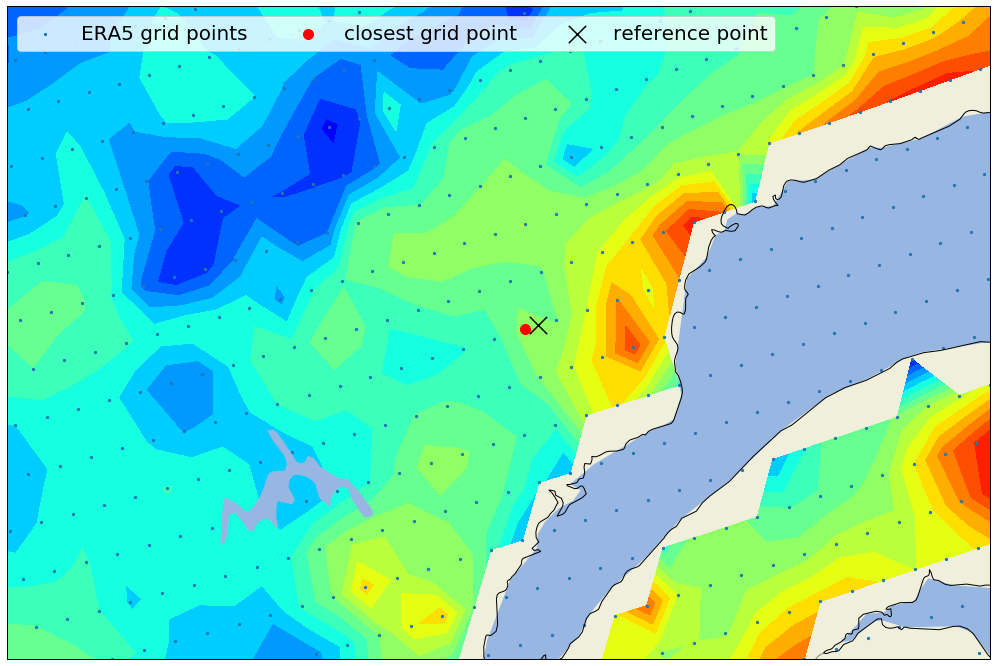

In [11]:
fig = plt.figure(figsize=(25,12))
ax = plt.subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-72,-65,49,51])
   # ax.coastlines(resolution='110m');
ax.add_feature(cfeature.OCEAN.with_scale('50m'))      # couche ocean
ax.add_feature(cfeature.LAND.with_scale('50m'))       # couche land
ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac    
ax.add_feature(cfeature.BORDERS.with_scale('50m'))    # couche frontieres
ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche rivières 
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',     # ajout de la couche cotière 
                        facecolor='none', name='coastline')
ax.add_feature(coast, edgecolor='black')

  
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

ax.add_feature(states_provinces, edgecolor='gray')

## Choisissons une colormap
cmap0=plt.cm.jet
cmap0.set_under('darkblue') ## on met en blanc les valeurs inferieures au min de clev
cmap0.set_over('darkred') ## bleu fonce pour les valeurs extremes de pluie

mm = ax.contourf(TAS.lon,\
                   TAS.lat,\
                   TAS.sel(time='2018-08-01').FWI,\
                   vmin=0,\
                   vmax=20, \
                   transform=ccrs.PlateCarree(),\
                   levels=np.arange(0, 20, 1.0),\
                   cmap=cmap0 )
ax.scatter(lon2d, lat2d, transform=ccrs.PlateCarree(), s=5, label='ERA5 grid points')
ax.scatter(TAS.sel(time='2018-08-01').FWI[latpt,lonpt].lon, 
           TAS.sel(time='2018-08-01').FWI[latpt,lonpt].lat, 
           color='r', transform=ccrs.PlateCarree(), s=100, label='closest grid point')
ax.scatter(-68.1461, 50, transform=ccrs.PlateCarree(), marker='x', color='black', s=300, label='reference point')
plt.legend(loc='upper left', numpoints=1, ncol=3, fontsize=20)


### Nearest neighbours k=10

We will now make the same exercice using k=10. 

In [14]:
site = (50, -68.1461)
d, inds, w, indslatlon = latlon_tree.query(site, k=10)
print(d)
print(w)
print(inds)
print(indslatlon)

[[ 7.44918778 10.47474677 25.37308687 28.39863145 28.78330094 28.79213291
  29.70566615 29.72368634 37.59953757 37.68733316]]
[[0.01802114 0.00911408 0.00155329 0.00123995 0.00120703 0.00120629
  0.00113324 0.00113187 0.00070735 0.00070406]]
[[5871 5872 5870 5873 5750 5992 5751 5993 5749 5991]]
(array([[48, 48, 48, 48, 47, 49, 47, 49, 47, 49]], dtype=int64), array([[63, 64, 62, 65, 63, 63, 64, 64, 62, 62]], dtype=int64))


In [15]:
TAS.sel(time='2018-08-01').FWI.values.flatten()[inds]

array([[10.517308  ,  9.87137321,  8.57146189, 11.99096501,  9.32552318,
        10.0954969 ,  9.84150618, 11.8046335 ,  9.26170112,  8.3454113 ]])

In [16]:
latpts = indslatlon[0][0]
lonpts = indslatlon[1][0]
print(latpts, lonpts)

[48 48 48 48 47 49 47 49 47 49] [63 64 62 65 63 63 64 64 62 62]


We can know Interpolate our field using inverse distance weighting, using 10 nearest neighbours (k=10):

(i.e. Tt=∑mi=1Ts,iwi∑mi=1wi, wi=1/d2i).

In [17]:
np.sum(w * TAS.sel(time='2018-08-01').FWI.values.flatten()[inds], axis=1) / np.sum(w, axis=1)

array([10.21868978])

Let's make a quick look:

In [18]:
latpts = indslatlon[0][0]
lonpts = indslatlon[1][0]

In [19]:
TAS.sel(time='2018-08-01').FWI[latpts,lonpts].lon

<xarray.DataArray 'lon' (lon: 10)>
array([-68.25, -68.  , -68.5 , -67.75, -68.25, -68.25, -68.  , -68.  , -68.5 ,
       -68.5 ])
Coordinates:
  * lon      (lon) float64 -68.25 -68.0 -68.5 -67.75 ... -68.0 -68.0 -68.5 -68.5
    time     datetime64[ns] 2018-08-01

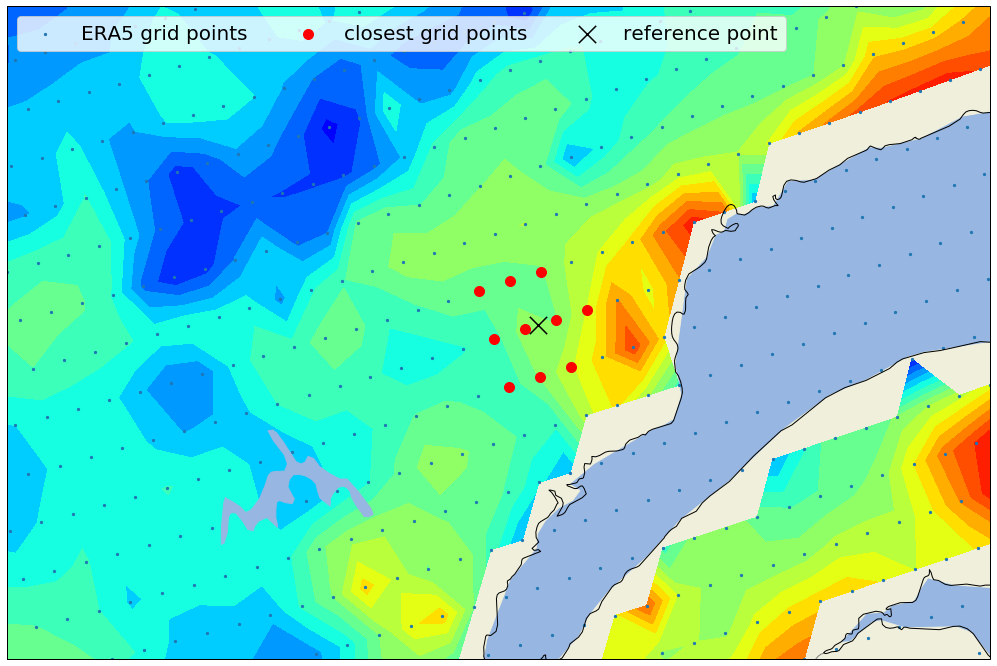

In [20]:
fig = plt.figure(figsize=(25,12))
ax = plt.subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-72,-65,49,51])
   # ax.coastlines(resolution='110m');
ax.add_feature(cfeature.OCEAN.with_scale('50m'))      # couche ocean
ax.add_feature(cfeature.LAND.with_scale('50m'))       # couche land
ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac    
ax.add_feature(cfeature.BORDERS.with_scale('50m'))    # couche frontieres
ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche rivières 
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',     # ajout de la couche cotière 
                        facecolor='none', name='coastline')
ax.add_feature(coast, edgecolor='black')

  
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

ax.add_feature(states_provinces, edgecolor='gray')

## Choisissons une colormap
cmap0=plt.cm.jet
cmap0.set_under('darkblue') ## on met en blanc les valeurs inferieures au min de clev
cmap0.set_over('darkred') ## bleu fonce pour les valeurs extremes de pluie

mm = ax.contourf(TAS.lon,\
                   TAS.lat,\
                   TAS.sel(time='2018-08-01').FWI,\
                   vmin=0,\
                   vmax=20, \
                   transform=ccrs.PlateCarree(),\
                   levels=np.arange(0, 20, 1.0),\
                   cmap=cmap0 )
ax.scatter(lon2d, lat2d, transform=ccrs.PlateCarree(), s=5, label='ERA5 grid points')
ax.scatter(TAS.sel(time='2018-08-01').FWI[latpts,lonpts].lon, 
           TAS.sel(time='2018-08-01').FWI[latpts,lonpts].lat, 
           color='r', transform=ccrs.PlateCarree(), s=100, label='closest grid points')
ax.scatter(-68.1461, 50, transform=ccrs.PlateCarree(), marker='x', color='black', s=300, label='reference point')
plt.legend(loc='upper left', numpoints=1, ncol=3, fontsize=20)

Now we will find all grid points  within a given distance from a reference point, by using the query_ball_point method in SciPy’s KD-tree implementation.

Let’s find out which ground pixels fall into a 700km radius from our reference point:

In [23]:
ball_point_index = latlon_tree.query_ball_point(site, 50)
lons = TAS.sel(time='2018-08-01').FWI[ball_point_index].lon
lats = TAS.sel(time='2018-08-01').FWI[ball_point_index].lat

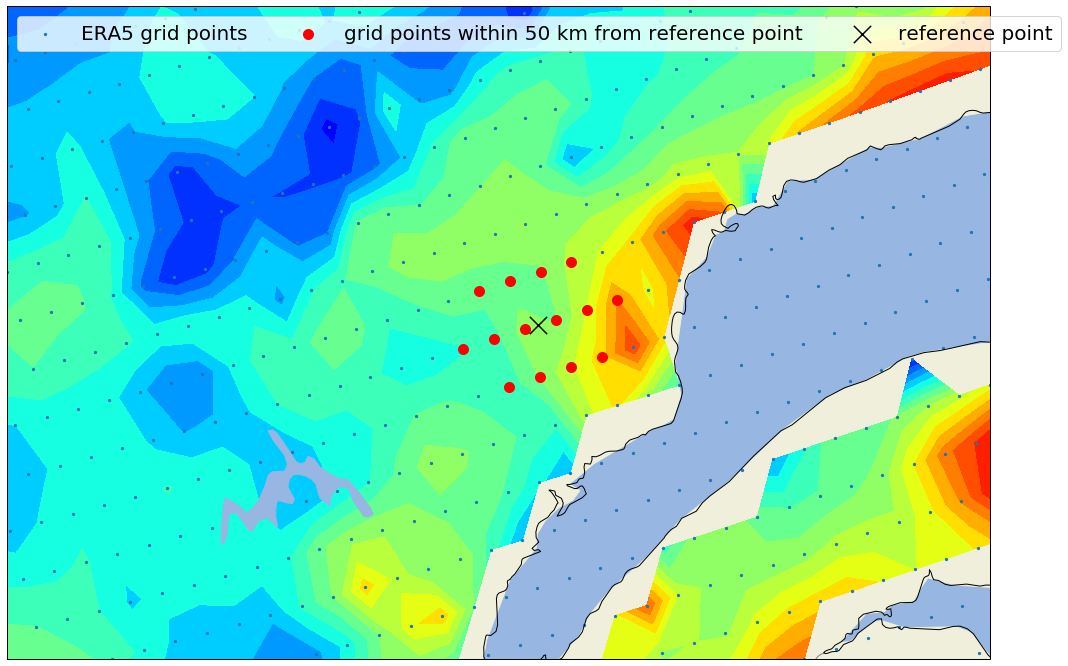

In [24]:
fig = plt.figure(figsize=(25,12))
ax = plt.subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-72,-65,49,51])
   # ax.coastlines(resolution='110m');
ax.add_feature(cfeature.OCEAN.with_scale('50m'))      # couche ocean
ax.add_feature(cfeature.LAND.with_scale('50m'))       # couche land
ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac    
ax.add_feature(cfeature.BORDERS.with_scale('50m'))    # couche frontieres
ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche rivières 
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',     # ajout de la couche cotière 
                        facecolor='none', name='coastline')
ax.add_feature(coast, edgecolor='black')

  
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

ax.add_feature(states_provinces, edgecolor='gray')

## Choisissons une colormap
cmap0=plt.cm.jet
cmap0.set_under('darkblue') ## on met en blanc les valeurs inferieures au min de clev
cmap0.set_over('darkred') ## bleu fonce pour les valeurs extremes de pluie

mm = ax.contourf(TAS.lon,\
                   TAS.lat,\
                   TAS.sel(time='2018-08-01').FWI,\
                   vmin=0,\
                   vmax=20, \
                   transform=ccrs.PlateCarree(),\
                   levels=np.arange(0, 20, 1.0),\
                   cmap=cmap0 )
ax.scatter(lon2d, lat2d, transform=ccrs.PlateCarree(), s=5, label='ERA5 grid points')
ax.scatter(lons, 
           lats, 
           color='r', transform=ccrs.PlateCarree(), s=100, label='grid points within 50 km from reference point')
ax.scatter(-68.1461, 50, transform=ccrs.PlateCarree(), marker='x', color='black', s=300, label='reference point')
plt.legend(loc='upper left', numpoints=1, ncol=3, fontsize=20)